Init train dataset with 3875 PNEUMONIA images and 1341 NORMAL images.
Init test dataset with 390 PNEUMONIA images and 234 NORMAL images.
activations hooked:  torch.Size([1, 2048, 7, 7])
activations hooked:  torch.Size([1, 2048, 7, 7])
activations hooked:  torch.Size([1, 2048, 7, 7])
activations hooked:  torch.Size([1, 2048, 7, 7])
activations hooked:  torch.Size([1, 2048, 7, 7])


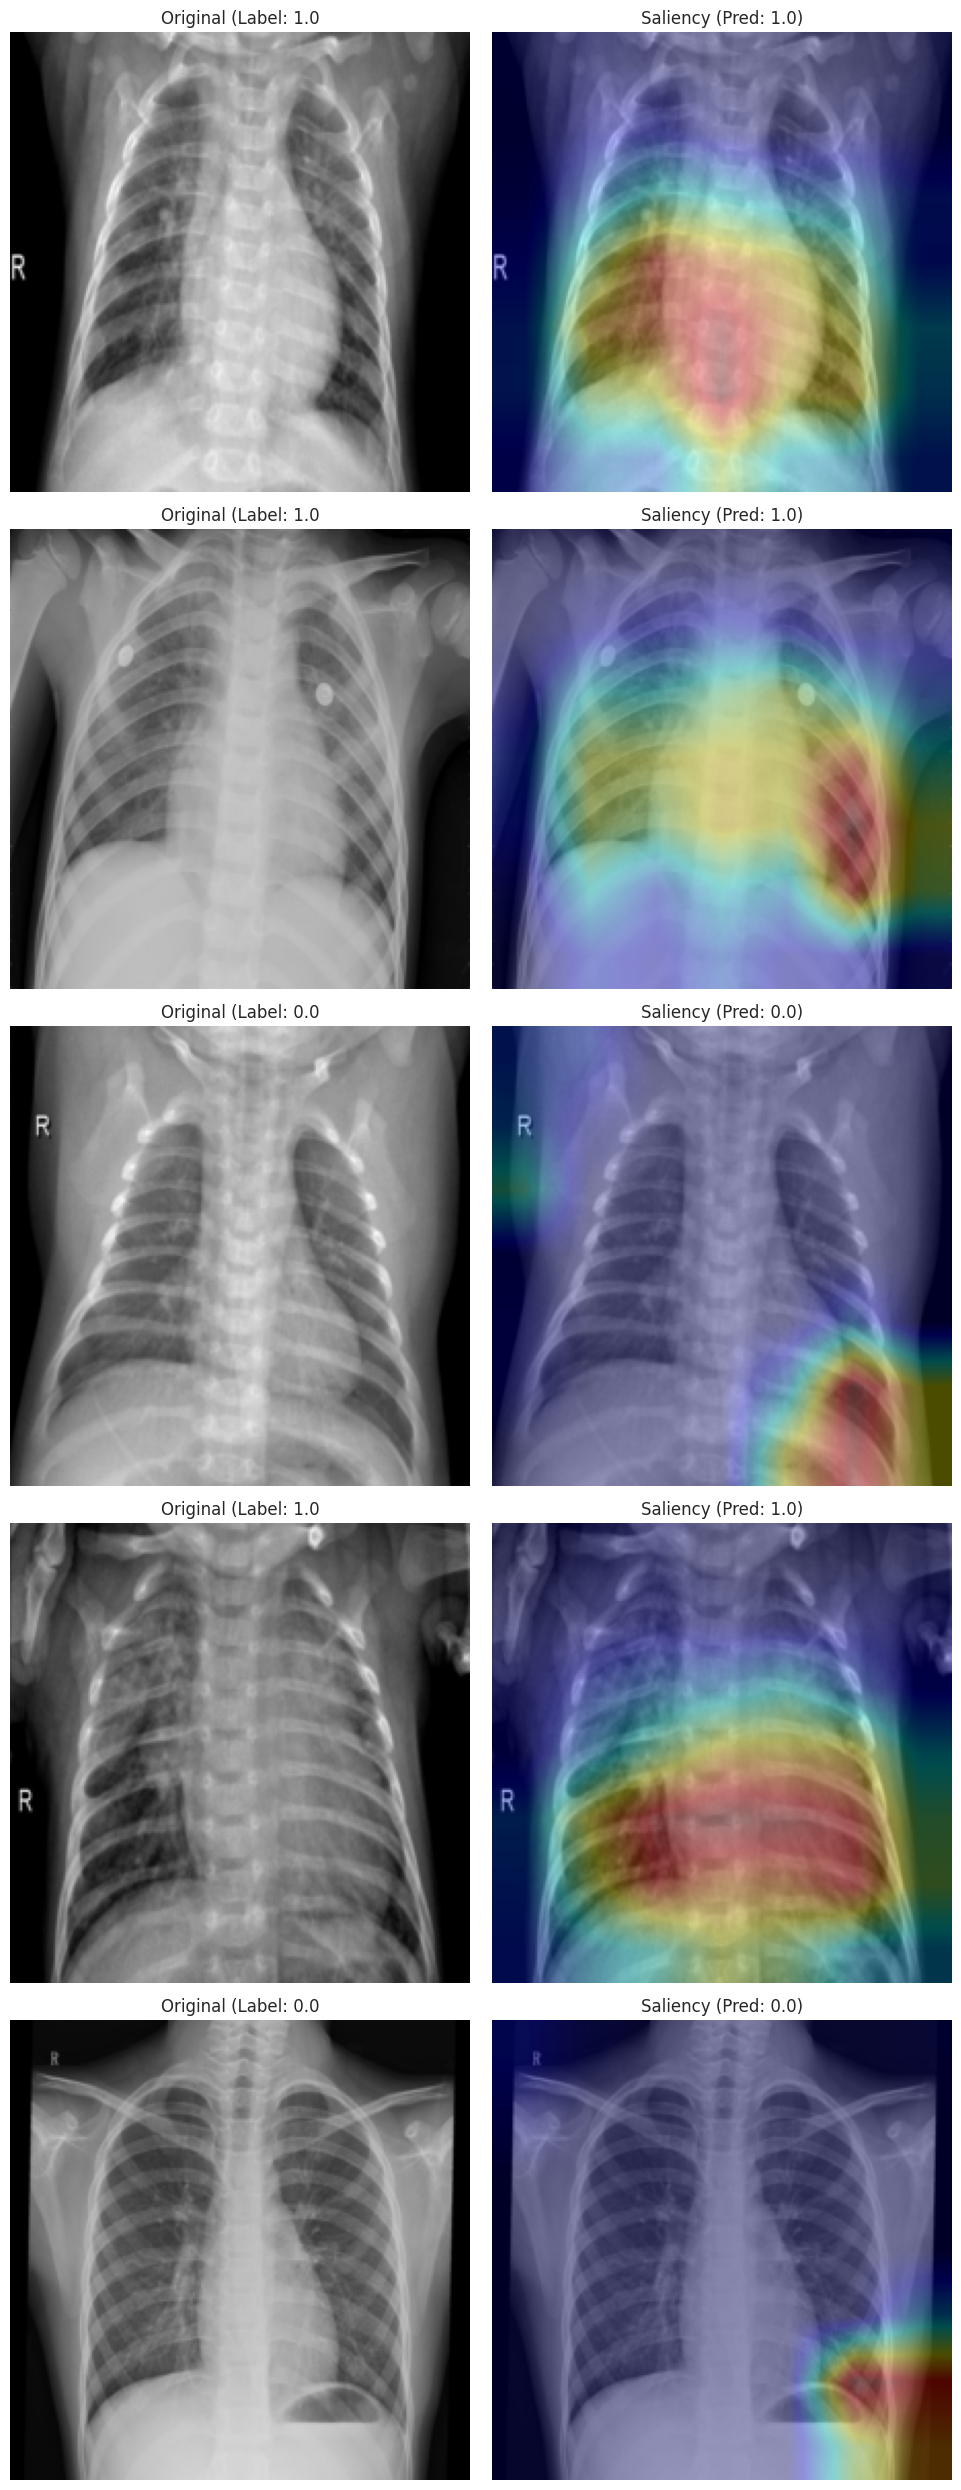

In [36]:
import datamodule
import models
import saliency
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import BaseConfig
import torch

reload(datamodule)
reload(models)
reload(saliency)

PATH_TO_CKPT = "/home/brimax/repos/medimg-saliency-benchmark/medimg-saliency-benchmark/checkpoints/_0.05.ckpt"
ALPHA = 0.3
N = 5  # Number of images to sample
device = "cuda" if torch.cuda.is_available() else "cpu"

def overlay_gradcam_on_image(img_tensor, cam, alpha=0.5):
    # img_tensor: shape [1, 3, H, W] (unnormalized, float [0,1])
    img_np = img_tensor.squeeze(0).detach().cpu().numpy()  # [3, H, W]
    img_np = np.transpose(img_np, (1, 2, 0))      # [H, W, 3]
    img_np = (img_np * 255).astype(np.uint8)

    # Resize cam to match image size
    cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Blend heatmap with original image
    overlay = cv2.addWeighted(img_np, 1 - alpha, heatmap, alpha, 0)
    return overlay

config = BaseConfig("./config.json")
dm = datamodule.Datamodule(config)
dm.setup()
dl = dm.test_dataloader()

# Sample N random indices
indices = np.random.choice(len(dm.test_ds), N, replace=False)
# indices = np.arange(390, 390+N)
# Fetch the corresponding batch of images
images = []
labels = []
for idx in indices:
    X, y = dm.test_ds[idx]
    images.append(X)
    labels.append(y)

# Convert lists to tensors
X = torch.stack(images).to(device)
y = torch.tensor(labels).to(device)

model = models.BaseCNN.load_from_checkpoint(PATH_TO_CKPT).to(device)
model.eval()
pred = model.predict(X)

gcam = saliency.CAM(model.model)
cams = []

for i in range(N):
    single_cam = gcam(X[[i]])  # Add batch dimension with X[[i]]
    cams.append(single_cam)
# Plotting
fig, axes = plt.subplots(N, 2, figsize=(10, 5*N))  # Adjust figure size as needed

for i in range(N):
    # Original Image
    img = X[i].permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype(np.uint8)
    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Original (Label: {y[i].item()}")

    # GradCAM Overlay
    overlay = overlay_gradcam_on_image(X[i:i+1], cams[i], alpha=ALPHA)
    axes[i, 1].imshow(overlay)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Saliency (Pred: {pred[i].item()})")

plt.tight_layout()
plt.show()

In [2]:
# Parse the results to write in a nice latex table
import json
import os

# Parse the JSON file
def parse_json_and_format_for_latex(json_data):
    # Load the JSON data
    data = json_data
    
    # Extract the results
    results = data["results"][0]
    
    # Format the metrics with confidence intervals
    # We'll round to 3 decimal places and format as "mean ± half_width"
    metrics = {}
    
    # Calculate and format each metric
    metrics["accuracy"] = f"{results['test/accuracy_mean']:.3f},{(results['test/accuracy_ci_upper'] - results['test/accuracy_ci_lower'])/2:.3f}"
    metrics["precision"] = f"{results['test/precision_mean']:.3f},{(results['test/precision_ci_upper'] - results['test/precision_ci_lower'])/2:.3f}"
    metrics["recall"] = f"{results['test/recall_mean']:.3f},{(results['test/recall_ci_upper'] - results['test/recall_ci_lower'])/2:.3f}"
    metrics["f1"] = f"{results['test/f1_mean']:.3f},{(results['test/f1_ci_upper'] - results['test/f1_ci_lower'])/2:.3f}"
    metrics["auroc"] = f"{results['test/auroc_mean']:.3f},{(results['test/auroc_ci_upper'] - results['test/auroc_ci_lower'])/2:.3f}"
    
    # Print the formatted metrics for LaTeX table
    # print("Formatted metrics for LaTeX table:")
    # print(f"Accuracy: {metrics['accuracy']}")
    # print(f"Precision: {metrics['precision']}")
    # print(f"Recall: {metrics['recall']}")
    # print(f"ROC AUC: {metrics['auroc']}")
    
    # Return the metrics dictionary
    return metrics

for evals in os.listdir("evaluation"):
    # print()
    model, linear, pretrained = evals.split("_")[:3]

    with open(f"evaluation/{evals}", "r") as f:
        res = json.load(f)
    metrics = parse_json_and_format_for_latex(res)
    with open("tmp.txt", "a") as f:
        f.write(f"{model},{linear},{pretrained},{metrics['accuracy']},{metrics['precision']},{metrics['recall']},{metrics['f1']},{metrics['auroc']}\n")

In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Parse the JSON file and extract metrics with confidence intervals
def parse_json_and_extract_metrics(json_data):
    # Load the JSON data
    data = json_data
    
    # Extract the results
    results = data["results"][0]
    
    # Store mean values and confidence intervals
    metrics = {}
    
    # Calculate mean and half width of confidence interval for each metric
    metrics["accuracy"] = {
        "mean": results['test/accuracy_mean'],
        "ci_half": (results['test/accuracy_ci_upper'] - results['test/accuracy_ci_lower'])/2
    }
    metrics["precision"] = {
        "mean": results['test/precision_mean'],
        "ci_half": (results['test/precision_ci_upper'] - results['test/precision_ci_lower'])/2
    }
    metrics["recall"] = {
        "mean": results['test/recall_mean'],
        "ci_half": (results['test/recall_ci_upper'] - results['test/recall_ci_lower'])/2
    }
    metrics["f1"] = {
        "mean": results['test/f1_mean'],
        "ci_half": (results['test/f1_ci_upper'] - results['test/f1_ci_lower'])/2
    }
    metrics["auroc"] = {
        "mean": results['test/auroc_mean'],
        "ci_half": (results['test/auroc_ci_upper'] - results['test/auroc_ci_lower'])/2
    }
    
    return metrics

# Process all evaluation files and store results in a DataFrame
def process_evaluation_files(eval_dir="evaluation"):
    data = []
    
    for evals in os.listdir(eval_dir):
        model, linear, pretrained = evals.split("_")[:3]
        
        with open(f"{eval_dir}/{evals}", "r") as f:
            res = json.load(f)
        
        metrics = parse_json_and_extract_metrics(res)
        
        # Create a row for this model
        row = {
            'model': model,
            'linear': linear,
            'pretrained': pretrained,
            'model_name': f"{model}_{linear}_{pretrained}"
        }
        
        # Add all metrics to the row
        for metric_name, metric_values in metrics.items():
            row[f"{metric_name}_mean"] = metric_values["mean"]
            row[f"{metric_name}_ci_half"] = metric_values["ci_half"]
        
        data.append(row)
    
    return pd.DataFrame(data)

# Create bar plots with confidence intervals for each metric
def plot_metrics(df):
    # List of metrics to plot
    metrics = ["accuracy", "precision", "recall", "f1", "auroc"]
    
    # Set up the figure size and style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['figure.figsize'] = (15, 10)
    
    for metric in metrics:
        plt.figure()
        
        # Prepare data for plotting
        model_names = df['model_name']
        means = df[f'{metric}_mean']
        errors = df[f'{metric}_ci_half']
        
        # Create bar plot with error bars
        plt.bar(model_names, means, yerr=errors, capsize=10, color='skyblue', edgecolor='black')
        
        # Customize the plot
        plt.title(f'{metric.upper()} with 95% Confidence Intervals', fontsize=16)
        plt.xlabel('Models', fontsize=14)
        plt.ylabel(f'{metric.capitalize()}', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        # Add grid for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Save the figure
        plt.savefig(f'plots/{metric}_barplot.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    print(f"Generated plots for {', '.join(metrics)}")

# Alternative: Create a single plot with all metrics using seaborn
def plot_all_metrics_together(df):
    # Melt the DataFrame to have metrics as a categorical variable
    metrics_cols = ['accuracy_mean', 'precision_mean', 'recall_mean', 'f1_mean', 'auroc_mean']
    ci_cols = ['accuracy_ci_half', 'precision_ci_half', 'recall_ci_half', 'f1_ci_half', 'auroc_ci_half']
    
    # Create a long-form dataframe for seaborn
    melted_df = pd.melt(df, id_vars=['model_name'], 
                        value_vars=metrics_cols,
                        var_name='metric', value_name='value')
    
    # Add CI information
    melted_df['metric_base'] = melted_df['metric'].str.replace('_mean', '')
    melted_ci = pd.melt(df, id_vars=['model_name'], 
                       value_vars=ci_cols,
                       var_name='ci_metric', value_name='ci')
    melted_ci['metric_base'] = melted_ci['ci_metric'].str.replace('_ci_half', '')
    
    # Merge the dataframes
    final_df = pd.merge(melted_df, melted_ci, on=['model_name', 'metric_base'])
    
    # Clean up the metric names for display
    final_df['clean_metric'] = final_df['metric'].str.replace('_mean', '').str.capitalize()
    
    # Create the plot
    plt.figure(figsize=(18, 10))
    
    # Plot grouped bar chart
    ax = sns.barplot(x='clean_metric', y='value', hue='model_name', data=final_df)
    
    # Add error bars
    x_coords = np.arange(len(final_df['clean_metric'].unique()))
    width = 0.8 / len(df['model_name'].unique())
    
    for i, model in enumerate(df['model_name'].unique()):
        model_data = final_df[final_df['model_name'] == model]
        x_pos = x_coords - 0.4 + width * (i + 0.5)
        plt.errorbar(x=x_pos, y=model_data['value'], yerr=model_data['ci'], 
                    fmt='none', capsize=5, ecolor='black', alpha=0.75)
    
    # Customize plot
    plt.title('Performance Metrics Comparison', fontsize=16)
    plt.xlabel('Metric', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Save figure
    plt.savefig('plots/all_metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Generated combined metrics plot")

# Example of how to run the code
if __name__ == "__main__":
    # Example usage with demonstration data
    # If you're testing without actual files, you can uncomment this block:
    """
    # Create sample data
    sample_data = []
    models = ['AlexNet', 'ResNet', 'VGG', 'InceptionNet']
    
    for model in models:
        # Create a mock data entry for each model
        row = {
            'model': model,
            'linear': 'linear',
            'pretrained': 'true',
            'model_name': model,
            'accuracy_mean': np.random.uniform(0.7, 0.9),
            'accuracy_ci_half': np.random.uniform(0.01, 0.03),
            'precision_mean': np.random.uniform(0.6, 0.8),
            'precision_ci_half': np.random.uniform(0.01, 0.03),
            'recall_mean': np.random.uniform(0.8, 1.0),
            'recall_ci_half': np.random.uniform(0.01, 0.03),
            'f1_mean': np.random.uniform(0.7, 0.9),
            'f1_ci_half': np.random.uniform(0.01, 0.03),
            'auroc_mean': np.random.uniform(0.7, 0.9),
            'auroc_ci_half': np.random.uniform(0.01, 0.03)
        }
        sample_data.append(row)
    
    df = pd.DataFrame(sample_data)
    """
    os.makedirs("plots", exist_ok=True)
    # Process all evaluation files
    try:
        df = process_evaluation_files()
        
        # Create individual plots for each metric
        plot_metrics(df)
        
        # Create a combined plot with all metrics
        plot_all_metrics_together(df)
        
    except FileNotFoundError:
        print("Evaluation directory not found. Please make sure the directory exists.")
        
        # For demonstration, you can use the sample data mentioned above
        print("Generating plots with sample data for demonstration...")
        
        # Create sample data
        sample_data = []
        models = ['AlexNet', 'ResNet', 'VGG', 'InceptionNet']
        
        for model in models:
            # Create a mock data entry for each model
            row = {
                'model': model,
                'linear': 'linear',
                'pretrained': 'true',
                'model_name': model,
                'accuracy_mean': np.random.uniform(0.7, 0.9),
                'accuracy_ci_half': np.random.uniform(0.01, 0.03),
                'precision_mean': np.random.uniform(0.6, 0.8),
                'precision_ci_half': np.random.uniform(0.01, 0.03),
                'recall_mean': np.random.uniform(0.8, 1.0),
                'recall_ci_half': np.random.uniform(0.01, 0.03),
                'f1_mean': np.random.uniform(0.7, 0.9),
                'f1_ci_half': np.random.uniform(0.01, 0.03),
                'auroc_mean': np.random.uniform(0.7, 0.9),
                'auroc_ci_half': np.random.uniform(0.01, 0.03)
            }
            sample_data.append(row)
        
        df = pd.DataFrame(sample_data)
        
        # Generate plots with sample data
        plot_metrics(df)
        plot_all_metrics_together(df)

Generated plots for accuracy, precision, recall, f1, auroc
Generated combined metrics plot


Init train dataset with 3875 PNEUMONIA images and 1341 NORMAL images.
Init test dataset with 390 PNEUMONIA images and 234 NORMAL images.


AlexNetBinary(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Linear(in_features=256, out_features=1, bias=True)
)

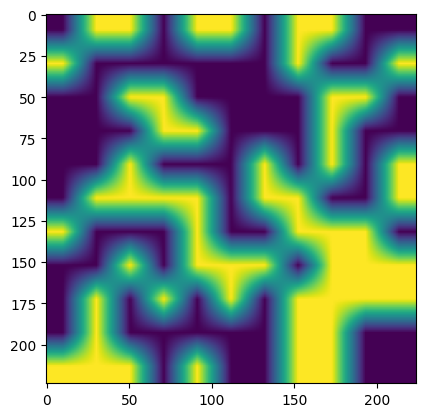

In [79]:
from datamodule import Datamodule
from utils import BaseConfig
import models
from importlib import reload
import torch
import saliency
import matplotlib.pyplot as plt
reload(models)
reload(saliency)
config = BaseConfig("config.json")
dm = Datamodule(config)
dm.setup() 
X, y = next(iter(dm.train_dataloader()))

model = models.AlexNetBinary(config)
# model = models.VGG16Binary(config)
# model = models.ResNet101Binary(config)
# model = models.InceptionNetBinary(config)
cam = saliency.RISE(model)

out = cam(X[[0]])

plt.imshow(out)
model

# Exploring Annotations

### 1. Imports and Setup

In [1]:
import json
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import importlib

import utils


BASE_ANNOTATIONS_DIR = "data/annotations"
METADATA_PATH = os.path.join(BASE_ANNOTATIONS_DIR, "metadata.json")
ANNOTATED_MASKS_DIR = os.path.join(BASE_ANNOTATIONS_DIR, "annotated")
ORIGINAL_IMAGES_DIR = os.path.join(BASE_ANNOTATIONS_DIR, "original")

TARGET_MASK_SIZE = (224, 224)

# Parameters for updated utils.process_circled_annotation TO BE TUNED!

CIRCLE_CLOSING_KERNEL_SIZE = 7 
CIRCLE_EROSION_KERNEL_SIZE = 7 
MIN_CONTOUR_AREA_FILTER = 20   

INITIAL_PRE_CLOSING_KERNEL_SIZE = 3  # For initial small gap closing (0 to disable)
SOLIDITY_THRESHOLD = 0.6             # Solidity < threshold means it's an OUTLINE. Range (0.0 to 1.0)
                                     # Lower for thinner/more broken outlines, Higher if outlines are quite solid.
OUTLINE_FILL_CLOSING_KERNEL_SIZE = 7 # To close gaps in detected outlines before filling (0 to disable)
OUTLINE_EROSION_KERNEL_SIZE = 7      # To "remove" line thickness from filled OUTLINES (0 to disable)
FILLED_REGION_HOLE_CLOSING_KERNEL_SIZE = 5 # To close internal holes in detected FILLED regions (0 to disable)
MIN_CONTOUR_AREA_FILTER = 20         # Minimum pixel area to consider a contour significant



### 2. Basics Statistics from Metadata

In [2]:
with open(METADATA_PATH, 'r') as f:
        annotations_metadata = json.load(f)
print(f"Successfully loaded metadata from: {METADATA_PATH}")
print(f"Total records in metadata: {len(annotations_metadata)}")
# Convert to DataFrame for easier analysis
df_metadata = pd.DataFrame(annotations_metadata)
print("\nFirst 5 records:")
print(df_metadata.head())


Successfully loaded metadata from: data/annotations/metadata.json
Total records in metadata: 97

First 5 records:
                          annotation_id                   image_name  \
0  d12d5736-247f-46c9-8aea-7179ec010bd7  person171_bacteria_826.jpeg   
1  1a73022a-19d7-412d-8e21-184a134f5aae   person91_bacteria_448.jpeg   
2  731e2a56-c3af-4328-9863-4a735a1f5461  person109_bacteria_528.jpeg   
3  850244f0-4b03-4aef-9c22-7a43adce12cd      person53_virus_107.jpeg   
4  a53cdfdb-39fc-4354-a57c-a1ff801d7236   person1664_virus_2877.jpeg   

     annotator_name  annotator_profession                 annotator_email  \
0          TESTJACK              TESTJACK                        TESTJACK   
1    davide-test-pc             tester-pc  davide.beltrame@studbocconi.it   
2    davide-test-pc             tester-pc  davide.beltrame@studbocconi.it   
3    davide-test-pc             tester-pc  davide.beltrame@studbocconi.it   
4  Tommaso Danielli  Studente di medicina                           

In [3]:
# Filter out test annotations, after printing them
print("\nTest annotations:")
print(df_metadata[df_metadata["annotator_name"].str.contains('test', case=False)])
df_metadata = df_metadata[~df_metadata['annotator_name'].str.contains('test', case=False)]

print(f"\nAfter filtering test annotations: {len(df_metadata)} records")


Test annotations:
                           annotation_id                   image_name  \
0   d12d5736-247f-46c9-8aea-7179ec010bd7  person171_bacteria_826.jpeg   
1   1a73022a-19d7-412d-8e21-184a134f5aae   person91_bacteria_448.jpeg   
2   731e2a56-c3af-4328-9863-4a735a1f5461  person109_bacteria_528.jpeg   
3   850244f0-4b03-4aef-9c22-7a43adce12cd      person53_virus_107.jpeg   
25  f6828321-dc2f-4033-ac8e-b687938d12e5       person38_virus_83.jpeg   

    annotator_name annotator_profession                 annotator_email  \
0         TESTJACK             TESTJACK                        TESTJACK   
1   davide-test-pc            tester-pc  davide.beltrame@studbocconi.it   
2   davide-test-pc            tester-pc  davide.beltrame@studbocconi.it   
3   davide-test-pc            tester-pc  davide.beltrame@studbocconi.it   
25       TESTJACK2            TESTJACK2                                   

                   timestamp  \
0   2025-05-09T11:46:12.642Z   
1   2025-05-09T12:16:41.916


--- Basic Statistics ---
Number of unique images with annotations: 50

Annotations per annotator:
annotator_name
giovanni p          50
Sara                20
Claudia             12
claudia              7
Tommaso Danielli     1
Diana                1
matilde              1
Name: count, dtype: int64

Annotator professions (one per annotator):
annotator_name
Claudia             Studente di medicina
Diana               Studente di medicina
Sara                      Specializzanda
Tommaso Danielli    Studente di medicina
claudia             studente di medicina
giovanni p              medico radiologo
matilde                studente medicina
Name: annotator_profession, dtype: object

Total number of annotations: 92

Annotations per image (distribution):
count    50.000000
mean      1.840000
std       0.710274
min       1.000000
25%       1.000000
50%       2.000000
75%       2.000000
max       3.000000
dtype: float64


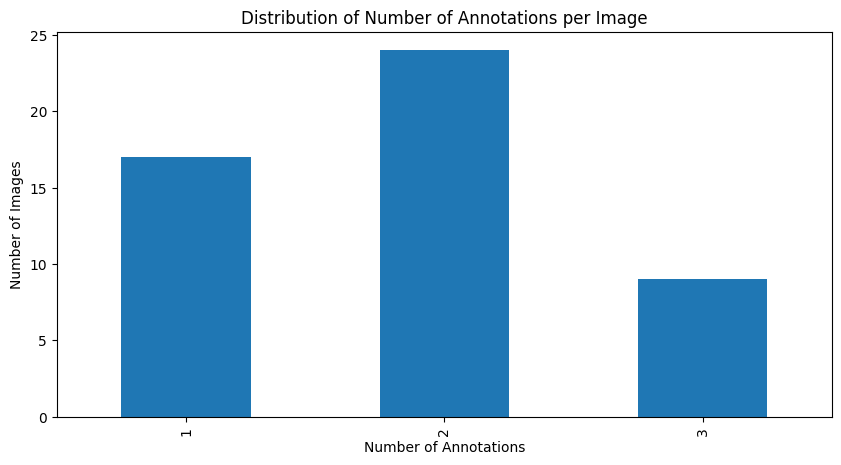

In [4]:
print("\n--- Basic Statistics ---")

num_unique_images = df_metadata['image_name'].nunique()
print(f"Number of unique images with annotations: {num_unique_images}")

print("\nAnnotations per annotator:")
print(df_metadata['annotator_name'].value_counts())

print("\nAnnotator professions (one per annotator):")
print(df_metadata.groupby('annotator_name')['annotator_profession'].first())

total_annotations = len(df_metadata)
print(f"\nTotal number of annotations: {total_annotations}")

print("\nAnnotations per image (distribution):")
annotations_per_image = df_metadata.groupby('image_name').size()
print(annotations_per_image.describe())

# Plot distribution of annotations per image
if not annotations_per_image.empty:
    plt.figure(figsize=(10, 5))
    annotations_per_image.value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of Number of Annotations per Image')
    plt.xlabel('Number of Annotations')
    plt.ylabel('Number of Images')
    plt.show()

### 3. Visualizing annotations


--- Testing utils.py and Visualizing ---

Processing image: person118_bacteria_560.jpeg
  Loaded original image from: data/annotations/original/person118_bacteria_560.jpeg
  Found 3 raw individual mask(s) for person118_bacteria_560.jpeg.
  Processing raw masks with 'utils.process_circled_annotation'...
  3 non-empty mask(s) for visualization after circle processing.
  Total 3 masks (incl. empty) sent for consensus.
  Consensus mask is empty or failed to create (which is expected if an expert provided an empty mask for intersection).


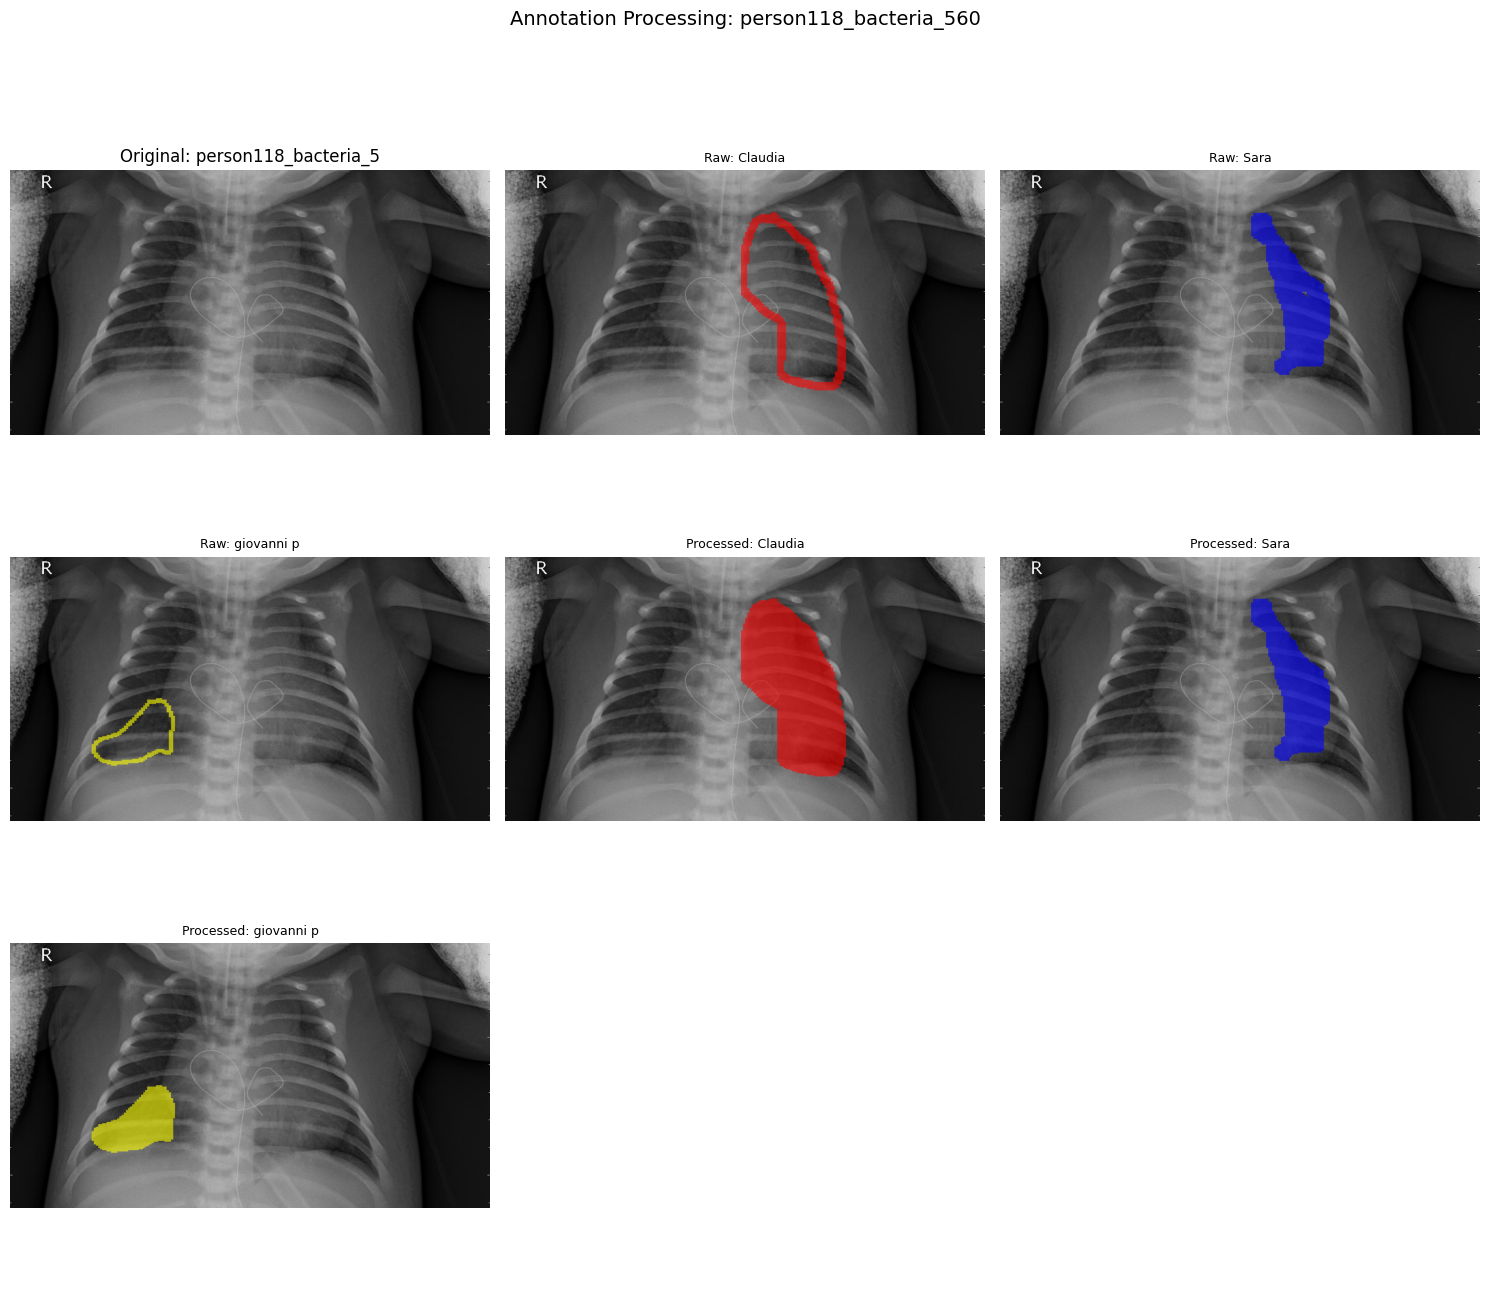


Processing image: person48_virus_100.jpeg
  Loaded original image from: data/annotations/original/person48_virus_100.jpeg
  Found 1 raw individual mask(s) for person48_virus_100.jpeg.
  Processing raw masks with 'utils.process_circled_annotation'...
  1 non-empty mask(s) for visualization after circle processing.
  Total 1 masks (incl. empty) sent for consensus.
  Consensus mask created with shape: (224, 224), Sum: 2231


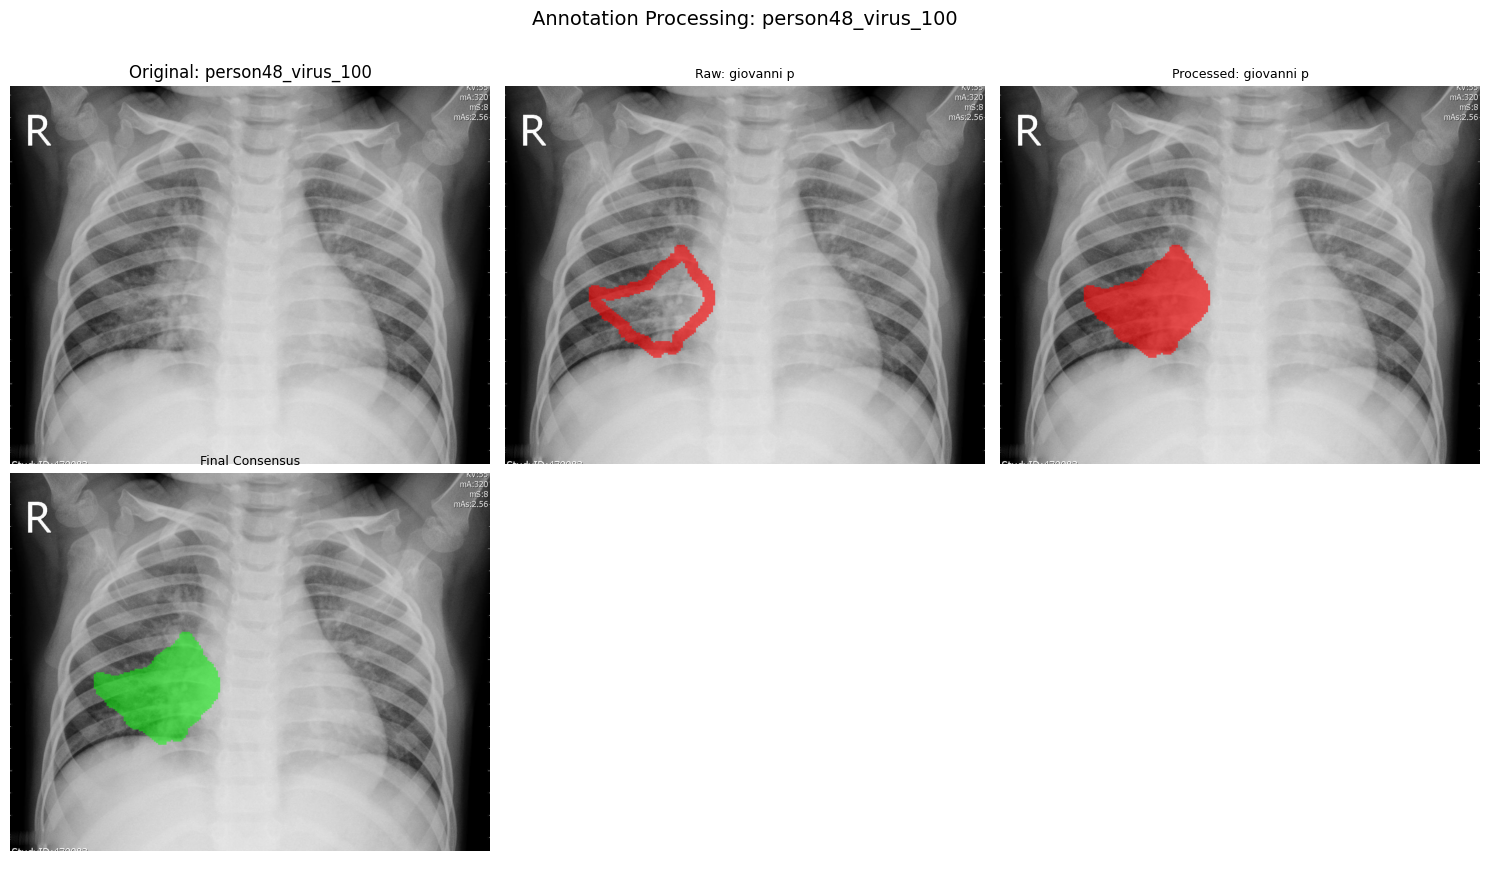

In [20]:
print("\n--- Testing utils.py and Visualizing ---")

sample_image_names = []
if not df_metadata.empty:
    image_counts = df_metadata['image_name'].value_counts()
    # Try to pick images with multiple annotations for diverse testing
    multi_annot_images = image_counts[image_counts > 1].index.tolist()
    single_annot_images = image_counts[image_counts == 1].index.tolist()
    
    if len(multi_annot_images) >= 1: # Prioritize multi-annotation images
        sample_image_names.extend(np.random.choice(multi_annot_images, size=min(1, len(multi_annot_images)), replace=False))
    if len(sample_image_names) < 2 and single_annot_images: # Fill with single annotation images if needed
            sample_image_names.extend(np.random.choice(single_annot_images, size=min(2-len(sample_image_names), len(single_annot_images)), replace=False))
    if not sample_image_names and not image_counts.empty: # Fallback
        sample_image_names.extend(np.random.choice(image_counts.index, size=min(2, len(image_counts.index)), replace=False))

if not sample_image_names:
    print("Could not select sample image names from metadata for visualization.")

for image_name in sample_image_names:
    print(f"\nProcessing image: {image_name}")
    original_image_path = os.path.join(ORIGINAL_IMAGES_DIR, image_name)
    try:
        original_pil_img = Image.open(original_image_path).convert("RGB")
        print(f"  Loaded original image from: {original_image_path}")
    except FileNotFoundError:
        print(f"  ERROR: Original image not found at {original_image_path}")
        continue
        
    # raw_masks_with_annotators will be a list of tuples: [(mask_array, annotator_name), ...]
    raw_masks_with_annotators = utils.get_masks_for_image_from_metadata(
        image_name,
        annotations_metadata,
        ANNOTATED_MASKS_DIR,
        target_size=TARGET_MASK_SIZE
    )
    
    if not raw_masks_with_annotators:
        print(f"  No raw masks found or loaded for {image_name}.")
        continue
    else:
        print(f"  Found {len(raw_masks_with_annotators)} raw individual mask(s) for {image_name}.")

    # Process raw circled annotations
    processed_masks_for_consensus_input = [] # This list will hold a mask for each annotator
    print(f"  Processing raw masks with 'utils.process_circled_annotation'...")
    for raw_mask, annotator_name in raw_masks_with_annotators: # raw_masks_with_annotators contains a mask for everyone
        processed_mask_output = utils.process_circled_annotation(
            raw_mask, # raw_mask itself could be an empty array if load_mask returned that
            initial_closing_kernel_size=INITIAL_PRE_CLOSING_KERNEL_SIZE,
            solidity_threshold=SOLIDITY_THRESHOLD,
            outline_fill_closing_kernel_size=OUTLINE_FILL_CLOSING_KERNEL_SIZE,
            outline_erosion_kernel_size=OUTLINE_EROSION_KERNEL_SIZE,
            filled_region_hole_closing_kernel_size=FILLED_REGION_HOLE_CLOSING_KERNEL_SIZE,
            min_contour_area=MIN_CONTOUR_AREA_FILTER
        )
        # Ensure process_circled_annotation always returns a mask (even if empty), not None
        if processed_mask_output is None:
                # This should ideally be handled inside process_circled_annotation to return empty array
                processed_mask_output = np.zeros(TARGET_MASK_SIZE, dtype=np.uint8)
        processed_masks_for_consensus_input.append(processed_mask_output) # Add all, even if empty

    # For visualization, we might still want to only show non-empty processed masks
    processed_masks_with_annotators_for_viz = []
    for i, (raw_mask_orig, annotator_name_orig) in enumerate(raw_masks_with_annotators):
        # Use the corresponding mask from processed_masks_for_consensus_input for visualization
        # This ensures we visualize what was actually sent for consensus
        corresponding_processed_mask = processed_masks_for_consensus_input[i]
        if corresponding_processed_mask.sum() > 0: # Only add to viz list if it has content
                processed_masks_with_annotators_for_viz.append((corresponding_processed_mask, annotator_name_orig))
    
    if not processed_masks_with_annotators_for_viz: # Check the list for visualization
        print(f"  No non-empty masks remained after circle processing for {image_name} (for visualization).")
    else:
        print(f"  {len(processed_masks_with_annotators_for_viz)} non-empty mask(s) for visualization after circle processing.")
        print(f"  Total {len(processed_masks_for_consensus_input)} masks (incl. empty) sent for consensus.")


    consensus_mask_np = None
    # Always attempt consensus if there were annotators, create_consensus_mask will handle empty list if needed
    # The list processed_masks_for_consensus_input will have one entry per annotator.
    if raw_masks_with_annotators: # Check if there were any raw masks to begin with
        consensus_mask_np = utils.create_consensus_mask(
            processed_masks_for_consensus_input, # Pass the list that includes potentially empty masks
            filter_type='open', 
            filter_kernel_size=3,
            consensus_method='intersection'
        )
        if consensus_mask_np is not None and consensus_mask_np.sum() > 0:
            print(f"  Consensus mask created with shape: {consensus_mask_np.shape}, Sum: {consensus_mask_np.sum()}")
        else:
            print("  Consensus mask is empty or failed to create (which is expected if an expert provided an empty mask for intersection).")
    else:
        print("  No raw masks available to create a consensus.")

    # Visualization
    num_raw_masks = len(raw_masks_with_annotators)
    num_processed_masks_viz = len(processed_masks_with_annotators_for_viz)

    total_plots = 1 + num_raw_masks + num_processed_masks_viz + (1 if consensus_mask_np is not None and consensus_mask_np.sum() > 0 else 0)
    
    if total_plots == 1:
            fig, ax = plt.subplots(1, 1, figsize=(5,5))
            ax.imshow(original_pil_img)
            ax.set_title(f"Original: {image_name.split('.')[0][:20]}")
            ax.axis('off')
    else:
        cols = min(total_plots, 3) # Adjusted to 3 for potentially longer titles
        rows = (total_plots + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4.5)) # Slightly taller for titles
        if total_plots == 1: axes = [axes]
        else: axes = axes.flatten()
        
        plot_idx = 0

        if plot_idx < len(axes): # Original Image
            axes[plot_idx].imshow(original_pil_img)
            axes[plot_idx].set_title(f"Original: {image_name.split('.')[0][:20]}")
            axes[plot_idx].axis('off'); plot_idx += 1

        colors = [(255,0,0), (0,0,255), (255,255,0), (0,255,255), (255,0,255)] 

        # Raw Individual Mask Overlays with Annotator Name
        for i, (raw_mask, annotator_name) in enumerate(raw_masks_with_annotators):
            if plot_idx < len(axes) and raw_mask is not None:
                overlay_raw_pil = utils.overlay_binary_mask(original_pil_img.copy(), raw_mask, mask_color=colors[i % len(colors)], alpha=0.6)
                axes[plot_idx].imshow(overlay_raw_pil)
                title_text = f"Raw: {annotator_name[:15]}" # Truncate annotator name if too long
                if len(annotator_name) > 15: title_text += "..."
                axes[plot_idx].set_title(title_text, fontsize=9) # Smaller font for potentially long names
                axes[plot_idx].axis('off'); plot_idx += 1
        
        # Processed Individual Mask Overlays with Annotator Name
        for i, (processed_mask, annotator_name) in enumerate(processed_masks_with_annotators_for_viz):
            if plot_idx < len(axes) and processed_mask is not None:
                overlay_processed_pil = utils.overlay_binary_mask(original_pil_img.copy(), processed_mask, mask_color=colors[i % len(colors)], alpha=0.6)
                axes[plot_idx].imshow(overlay_processed_pil)
                title_text = f"Processed: {annotator_name[:10]}" # Truncate
                if len(annotator_name) > 10: title_text += "..."
                axes[plot_idx].set_title(title_text, fontsize=9)
                axes[plot_idx].axis('off'); plot_idx += 1

        # Overlay Consensus Mask
        if consensus_mask_np is not None and consensus_mask_np.sum() > 0 and plot_idx < len(axes):
            overlay_consensus_pil = utils.overlay_binary_mask(original_pil_img.copy(), consensus_mask_np, mask_color=(0, 255, 0), alpha=0.5)
            axes[plot_idx].imshow(overlay_consensus_pil)
            axes[plot_idx].set_title("Final Consensus", fontsize=9)
            axes[plot_idx].axis('off'); plot_idx += 1
        
        for i in range(plot_idx, len(axes)): axes[i].axis('off')

    plt.suptitle(f"Annotation Processing: {image_name.split('.')[0][:30]}", fontsize=14)
    plt.tight_layout(rect=[0, 0.02, 1, 0.96]) # Adjust rect to prevent suptitle overlap
    plt.show()
    

### 4. IoU Examples

In [6]:
if len(df_metadata['image_name'].unique()) > 0 and annotations_metadata:
    print("\n--- Example: Inter-Rater Agreement (IoU) for one image ---")
    # Pick an image that has multiple annotations
    annotations_per_image = df_metadata.groupby('image_name').size()
    multi_annotated_images = annotations_per_image[annotations_per_image > 1].index.tolist()
    
    if multi_annotated_images:
        example_image_name_iou = np.random.choice(multi_annotated_images)
        print(f"Calculating IoU for annotators of image: {example_image_name_iou}")
        
        masks_for_iou = utils.get_masks_for_image_from_metadata(
            example_image_name_iou,
            annotations_metadata,
            ANNOTATED_MASKS_DIR,
            target_size=TARGET_MASK_SIZE
        )
        
        # Apply morphological opening as per your README description before IoU
        processed_masks_for_iou = []
        for m in masks_for_iou:
            processed_m = utils.apply_morphological_filter(m, operation='open', kernel_size=3)
            if processed_m is not None:
                 processed_masks_for_iou.append(processed_m)


        if len(processed_masks_for_iou) >= 2:
            # Calculate IoU for all pairs of annotators
            annotator_records = [rec for rec in annotations_metadata if rec['image_name'] == example_image_name_iou]

            for i in range(len(processed_masks_for_iou)):
                for j in range(i + 1, len(processed_masks_for_iou)):
                    mask1 = processed_masks_for_iou[i]
                    mask2 = processed_masks_for_iou[j]
                    iou_score = utils.calculate_iou(mask1, mask2)
                    
                    # Try to get annotator names for context, if available and match masks
                    annotator1_name = "N/A"
                    annotator2_name = "N/A"
                    # This matching is tricky if order from get_masks isn't guaranteed
                    # For simplicity, we'll just say Annotator i vs Annotator j
                    # A more robust way would be to return (mask, annotator_info) from get_masks

                    print(f"  IoU between mask {i+1} and mask {j+1}: {iou_score:.4f}")
        else:
            print(f"  Not enough masks ({len(processed_masks_for_iou)}) for {example_image_name_iou} to calculate pairwise IoU.")
    else:
        print("  No images found with multiple annotations to demonstrate IoU calculation.")


--- Example: Inter-Rater Agreement (IoU) for one image ---
Calculating IoU for annotators of image: person78_bacteria_385.jpeg


AttributeError: 'tuple' object has no attribute 'shape'